
Found 1161 valid input-output pairs.

Data verification:
Sample 1:
Even range: 0.00-1.00
Odd range: 0.00-1.00
Target unique values: [0. 1.]

Sample 2:
Even range: 0.00-1.00
Odd range: 0.00-0.99
Target unique values: [0. 1.]

Sample 3:
Even range: 0.00-1.00
Odd range: 0.00-1.00
Target unique values: [0. 1.]


Data verification:
Sample 1:
Even range: 0.00-1.00
Odd range: 0.00-1.00
Target unique values: [0. 1.]

Sample 2:
Even range: 0.00-1.00
Odd range: 0.00-1.00
Target unique values: [0. 1.]

Sample 3:
Even range: 0.00-1.00
Odd range: 0.00-1.00
Target unique values: [0. 1.]

Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.4962 - binary_io_u: 0.4320 - loss: 0.7446 - val_accuracy: 0.4999 - val_binary_io_u: 0.4999 - val_loss: 0.7109 - learning_rate: 1.0000e-04
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.4926 - binary_io_u: 0.4925 - loss: 0.6936 - val_accuracy: 0.4999 - val_binary_io_u: 0.4999 - val_loss: 0.6872 - learning_rate: 1.0000e-04
Epoch

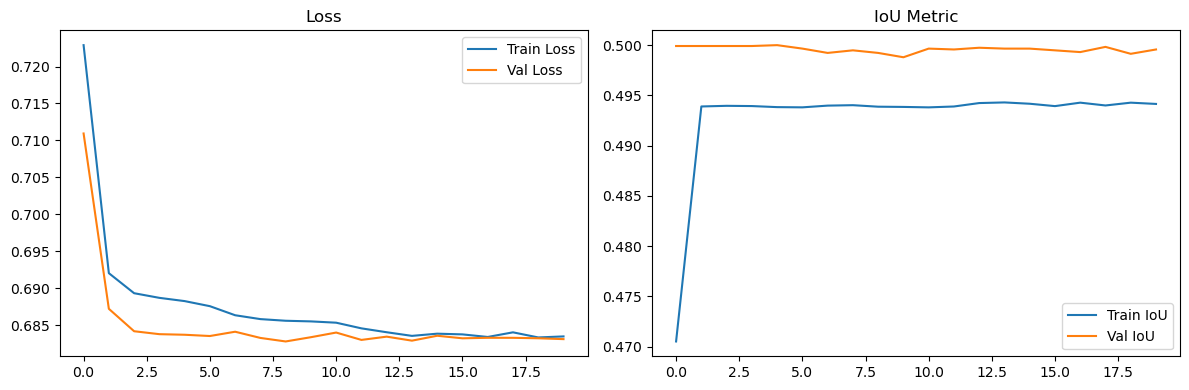

Evaluating model...
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5010 - binary_io_u: 0.5008 - loss: 0.6825
Validation Loss: 0.6837, Accuracy: 0.5001, IoU: 0.5000
Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


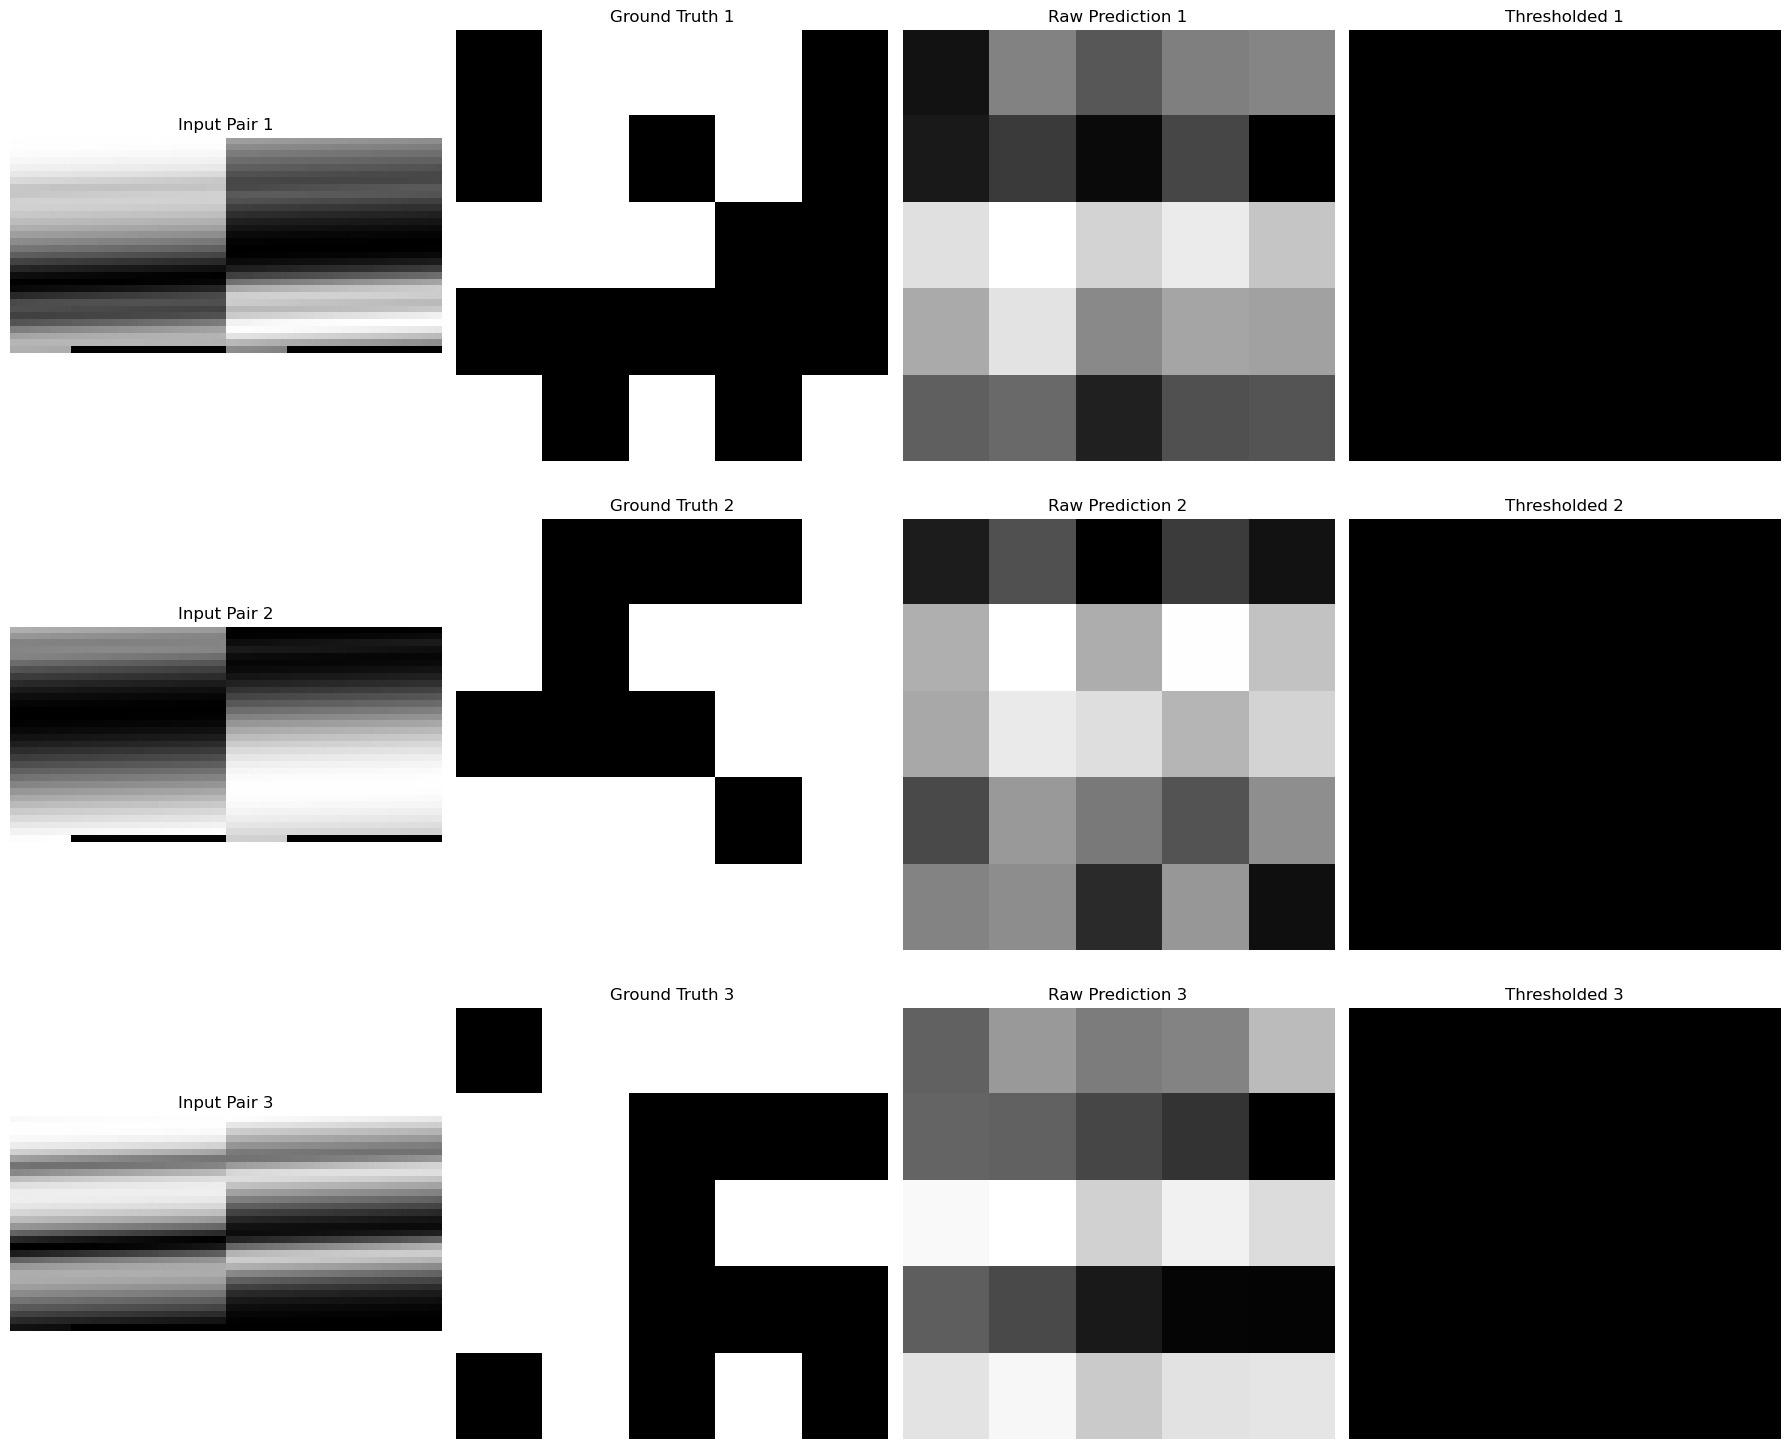

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
learning_rate = 1e-4  # Reduced learning rate
epochs = 100
block_size = 10

# Improved Custom Layer
class BlockUniformityLayer(layers.Layer):
    def __init__(self, block_size=10, **kwargs):
        super().__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 5, self.block_size, 5, self.block_size, 1])
        x = tf.reduce_mean(x, axis=[2, 4])  # -> (batch_size, 5, 5, 1)
        x = tf.repeat(x, self.block_size, axis=1)  # -> (batch_size, 50, 5, 1)
        x = tf.repeat(x, self.block_size, axis=2)  # -> (batch_size, 50, 50, 1)
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 50, 50, 1)

# Enhanced Loss Functions
def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (2. * intersection + smooth) / (union + smooth)

def weighted_binary_crossentropy(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    block_weight = tf.reduce_mean(tf.reshape(y_true, [-1, 5, block_size, 5, block_size, 1]), axis=[2, 4])
    block_weight = tf.where(block_weight > 0.5, 2.0, 1.0)
    block_weight = tf.repeat(tf.repeat(block_weight, block_size, axis=1), block_size, axis=2)
    block_weight = tf.squeeze(block_weight)
    weighted_bce = bce * block_weight
    return tf.reduce_mean(weighted_bce)

def combined_loss(y_true, y_pred):
    return 0.5*weighted_binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)

# Improved Model Architecture
def build_improved_model(input_shape, output_shape):
    # Input branches
    input_even = layers.Input(shape=input_shape, name="even_input")
    input_odd = layers.Input(shape=input_shape, name="odd_input")
    
    # Shared encoder
    def create_encoder(input_layer):
        x = layers.Conv2D(32, 3, padding="same", activation="relu")(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        return x
    
    # Process both inputs
    even_features = create_encoder(input_even)
    odd_features = create_encoder(input_odd)
    
    # Combine features
    x = layers.Concatenate()([even_features, odd_features])
    
    # Decoder
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    output = BlockUniformityLayer(block_size=10)(x)
    
    return models.Model(inputs=[input_even, input_odd], outputs=output)

# Enhanced Data Generator
class ImagePairGenerator(Sequence):
    def __init__(self, even_dir, odd_dir, out_dir, batch_size, input_shape, output_shape, pairs, augment=False):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs
        self.augment = augment
        self.augmentation = KerasImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='constant',
            cval=0.0
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape))
        odd_batch = np.zeros((len(batch), *self.input_shape))
        out_batch = np.zeros((len(batch), *self.output_shape))

        for i, (e_path, o_path, m_path) in enumerate(batch):
            try:
                # Load and preprocess images
                even = np.expand_dims(np.array(Image.open(e_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                odd = np.expand_dims(np.array(Image.open(o_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                
                # Process target matrix
                matrix_img = np.array(Image.open(m_path).convert('L').resize(self.output_shape[:2]))
                matrix_bin = (matrix_img > 128).astype(np.float32)
                matrix_bin = matrix_bin.reshape(5, block_size, 5, block_size).mean(axis=(1, 3))
                matrix_bin = np.repeat(np.repeat((matrix_bin > 0.5).astype(np.float32), block_size, axis=0), block_size, axis=1)
                matrix_bin = np.expand_dims(matrix_bin, -1)

                if self.augment:
                    seed = np.random.randint(1e6)
                    even = self.augmentation.random_transform(even, seed=seed)
                    odd = self.augmentation.random_transform(odd, seed=seed)

                even_batch[i] = even
                odd_batch[i] = odd
                out_batch[i] = matrix_bin
            except Exception as e:
                print(f"Error processing pair {e_path}, {o_path}, {m_path}: {str(e)}")
                continue

        return (even_batch, odd_batch), out_batch

# Data preparation and verification
def get_valid_pairs():
    pairs = []
    missing_ids = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
        else:
            missing_ids.append(base)
    if missing_ids:
        print(f"Warning: Missing input files for {len(missing_ids)} IDs")
    return pairs

# Enhanced visualization
def visualize_predictions(model, generator, num_samples=3):
    (even_inputs, odd_inputs), true_outputs = generator[0]
    predictions = model.predict([even_inputs, odd_inputs])
    
    plt.figure(figsize=(18, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        # Show input pairs
        plt.subplot(num_samples, 4, 1 + i*4)
        plt.imshow(np.hstack([even_inputs[i].squeeze(), odd_inputs[i].squeeze()]), cmap='gray')
        plt.title(f'Input Pair {i+1}')
        plt.axis('off')
        
        # Show ground truth
        plt.subplot(num_samples, 4, 2 + i*4)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray')
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        
        # Show raw prediction
        plt.subplot(num_samples, 4, 3 + i*4)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f'Raw Prediction {i+1}')
        plt.axis('off')
        
        # Show thresholded prediction
        plt.subplot(num_samples, 4, 4 + i*4)
        plt.imshow((predictions[i] > 0.5).astype(float).squeeze(), cmap='gray')
        plt.title(f'Thresholded {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Data verification function
def verify_data(generator):
    print("\nData verification:")
    for i in range(3):
        (even, odd), target = generator[i]
        print(f"Sample {i+1}:")
        print(f"Even range: {even.min():.2f}-{even.max():.2f}")
        print(f"Odd range: {odd.min():.2f}-{odd.max():.2f}")
        print(f"Target unique values: {np.unique(target)}")
        print()

# Main execution
if __name__ == "__main__":
    # Prepare data
    pairs = get_valid_pairs()
    print(f"Found {len(pairs)} valid input-output pairs.")
    np.random.shuffle(pairs)
    split = int(0.8 * len(pairs))
    train_pairs = pairs[:split]
    val_pairs = pairs[split:]

    train_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, train_pairs, augment=True)
    val_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, val_pairs)

    # Verify data
    verify_data(train_gen)
    verify_data(val_gen)

    # Build and compile model
    model = build_improved_model(input_shape, output_shape)
    model.compile(
        optimizer=optimizers.Adam(learning_rate),
        loss=combined_loss,
        metrics=['accuracy', tf.keras.metrics.BinaryIoU(target_class_ids=[1])]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', 
                                         monitor='val_binary_io_u',
                                         mode='max',
                                         save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_io_u',
                                       patience=15,
                                       mode='max',
                                       restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_io_u',
                                           factor=0.5,
                                           patience=5,
                                           mode='max')
    ]

    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    # Save model
    model.save("image_translation_model_final.keras")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_io_u'], label='Train IoU')
    plt.plot(history.history['val_binary_io_u'], label='Val IoU')
    plt.title('IoU Metric')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate and visualize
    print("Evaluating model...")
    loss, accuracy, iou = model.evaluate(val_gen)
    print(f"Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, IoU: {iou:.4f}")

    print("Visualizing predictions...")
    visualize_predictions(model, val_gen)

Found 1161 valid input-output pairs.
Inspecting training data samples...
Even input shape: (4, 32, 32, 1)
Odd input shape: (4, 32, 32, 1)
Output shape: (4, 50, 50, 1)
Unique values in ground truth: [0. 1.]


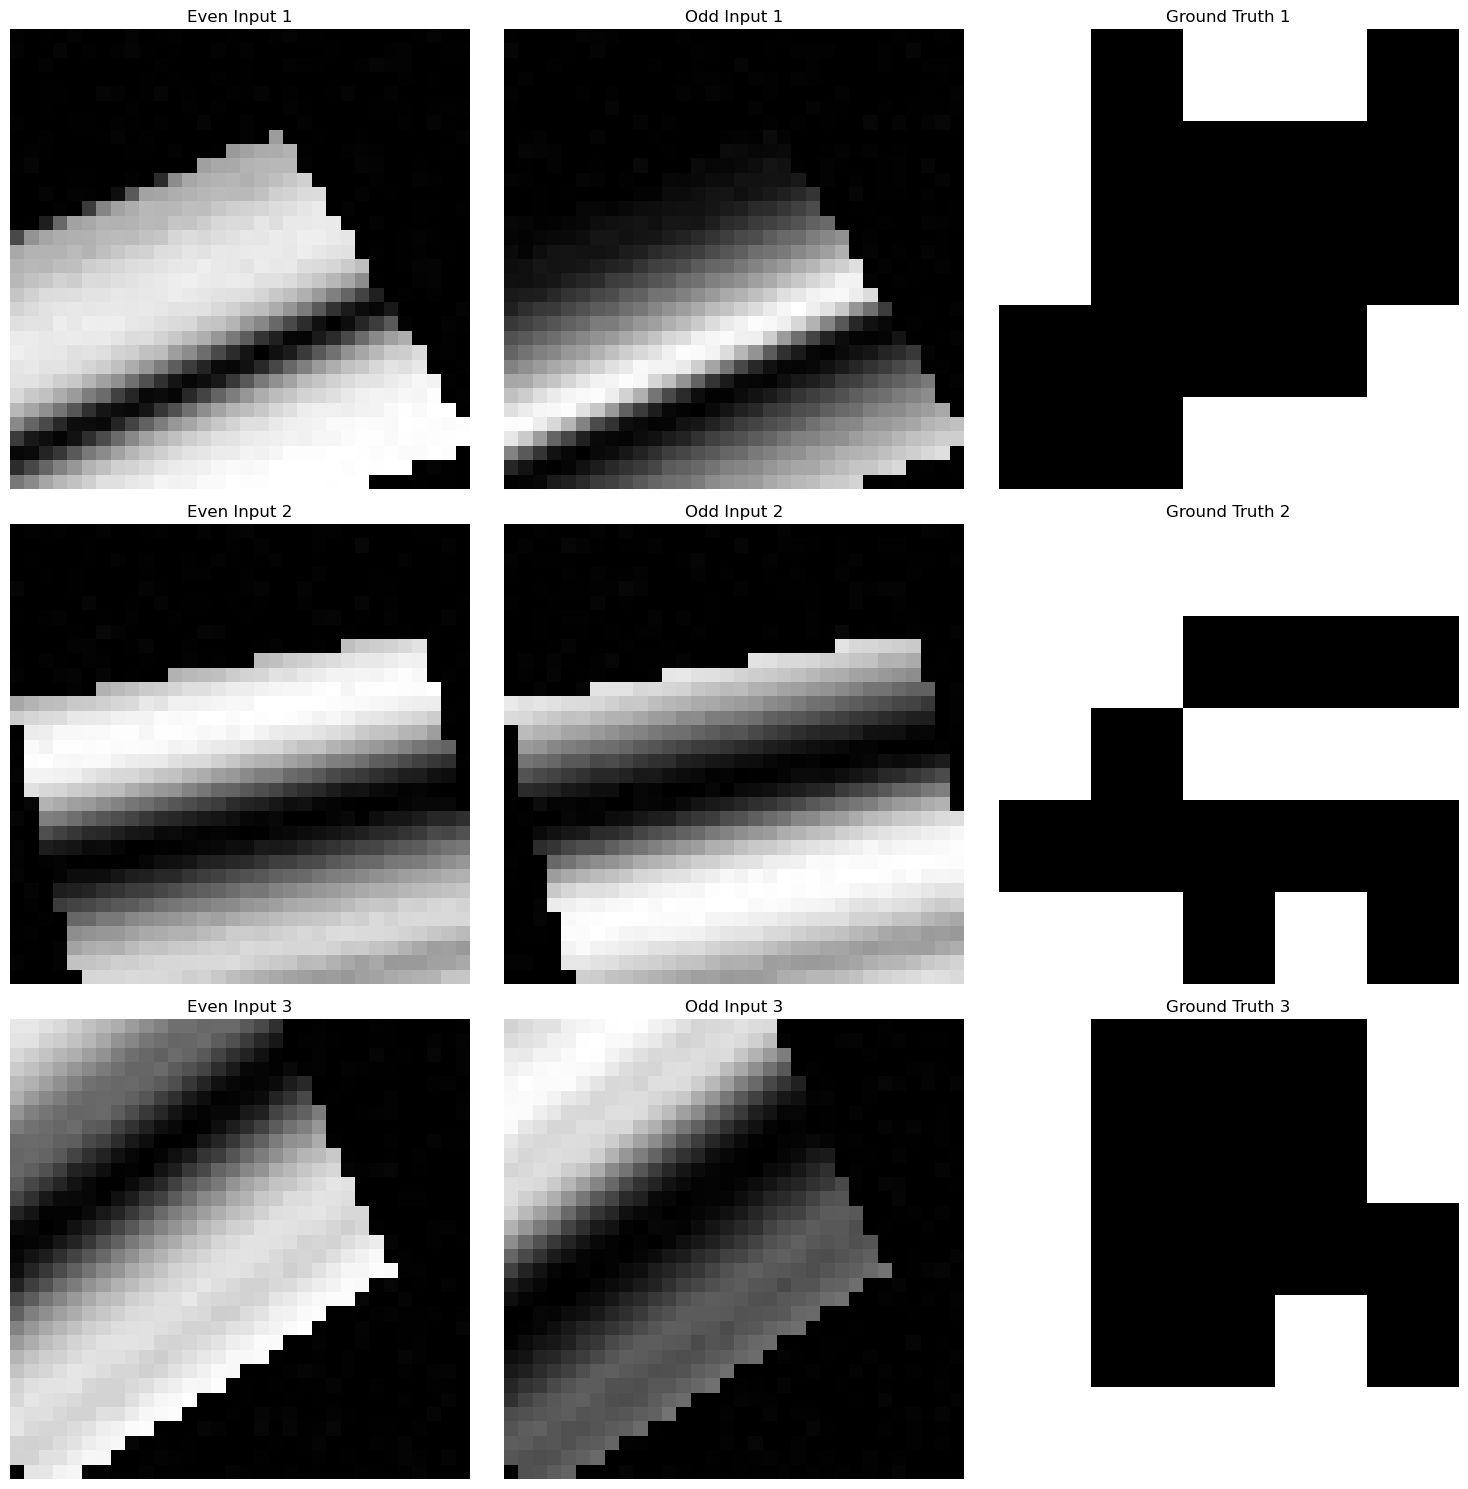

Starting training...
Epoch 1/200
Batch 1, Loss Value: 0.9508
Batch 1, Gradient Norm: 0.0424
  1/232 ━━━━━━━━━━━━━━━━━━━━ 1:10:01 18s/step - accuracy: 0.4100 - binary_io_u_5: 0.4200 - loss: 0.9413Batch 2, Loss Value: 0.9470
Batch 2, Gradient Norm: 0.9881
  2/232 ━━━━━━━━━━━━━━━━━━━━ 1:51 486ms/step - accuracy: 0.4350 - binary_io_u_5: 0.4300 - loss: 0.9420 Batch 3, Loss Value: 0.9415
Batch 3, Gradient Norm: 0.6809
  3/232 ━━━━━━━━━━━━━━━━━━━━ 1:51 488ms/step - accuracy: 0.4411 - binary_io_u_5: 0.4467 - loss: 0.9424Batch 4, Loss Value: 0.9112
Batch 4, Gradient Norm: 0.5679
  4/232 ━━━━━━━━━━━━━━━━━━━━ 1:50 487ms/step - accuracy: 0.4515 - binary_io_u_5: 0.4531 - loss: 0.9421Batch 5, Loss Value: 0.9479
Batch 5, Gradient Norm: 0.0294
  5/232 ━━━━━━━━━━━━━━━━━━━━ 1:50 486ms/step - accuracy: 0.4596 - binary_io_u_5: 0.4585 - loss: 0.9420Batch 6, Loss Value: 0.9269
Batch 6, Gradient Norm: 0.5636
  6/232 ━━━━━━━━━━━━━━━━━━━━ 1:49 484ms/step - accuracy: 0.4646 - binary_io_u_5: 0.4612 - loss: 0.942

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
learning_rate = 1e-3
epochs = 200
block_size = 10

# Attention Gate
def attention_gate(gating, skip, num_filters):
    g = layers.Conv2D(num_filters, 1, padding='same')(gating)
    x = layers.Conv2D(num_filters, 1, padding='same')(skip)
    x = layers.Add()([g, x])
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(1, 1, padding='same')(x)
    x = layers.Activation('sigmoid')(x)
    return layers.Multiply()([skip, x])

# Custom Layer
class BlockUniformityLayer(layers.Layer):
    def __init__(self, block_size=10, **kwargs):
        super().__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 5, self.block_size, 5, self.block_size, 1])
        x = tf.reduce_mean(x, axis=[2, 4])  # -> (batch_size, 5, 5, 1)
        x = tf.keras.activations.sigmoid(10.0 * (x - 0.5))  # Stable sigmoid
        x = tf.repeat(x, self.block_size, axis=1)  # -> (batch_size, 50, 5, 1)
        x = tf.repeat(x, self.block_size, axis=2)  # -> (batch_size, 50, 50, 1)
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 50, 50, 1)

# Loss Functions
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.clip_by_value(1 - dice, 0.0, 1.0)

def weighted_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.expand_dims(bce, axis=-1)
    block_weight = tf.reduce_mean(tf.reshape(y_true, [-1, 5, block_size, 5, block_size, 1]), axis=[2, 4])
    block_weight = tf.where(block_weight > 0.5, 2.0, 1.0)
    block_weight = tf.repeat(block_weight, block_size, axis=1)
    block_weight = tf.repeat(block_weight, block_size, axis=2)
    weighted_bce = tf.reduce_mean(bce * block_weight)
    return tf.clip_by_value(weighted_bce, 0.0, 1.0)

def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 0.9 * weighted_binary_crossentropy(y_true, y_pred) + 0.1 * dice_loss(y_true, y_pred)

# Fixed Gradient Debugging Callback
class GradientNormCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_gen):
        super().__init__()
        self.train_gen = train_gen
        
    def on_batch_end(self, batch, logs=None):
        model = self.model
        # Get a batch from the generator
        (even, odd), y_true = next(iter(self.train_gen))
        
        with tf.GradientTape() as tape:
            y_pred = model([even, odd], training=True)
            loss = model.loss(y_true, y_pred)
        
        loss_value = float(loss.numpy()) if tf.is_tensor(loss) else loss
        print(f"Batch {batch+1}, Loss Value: {loss_value:.4f}")
        
        grads = tape.gradient(loss, model.trainable_variables)
        grad_norms = [tf.norm(g).numpy() if g is not None else 0 for g in grads]
        total_grad_norm = np.sqrt(sum([g**2 for g in grad_norms]))
        print(f"Batch {batch+1}, Gradient Norm: {total_grad_norm:.4f}")

# Complex Model
def build_dual_input_model(input_shape, output_shape):
    input_even = layers.Input(shape=input_shape, name="even_input")
    input_odd = layers.Input(shape=input_shape, name="odd_input")

    # Feature Engineering: Compute statistics
    even_stats = layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True))(input_even)
    odd_stats = layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True))(input_odd)

    # Encoder
    def encoder_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        skip = x
        x = layers.MaxPooling2D()(x)
        return x, skip

    # Even branch
    e1, skip_e1 = encoder_block(input_even, 64)
    e2, skip_e2 = encoder_block(e1, 128)
    e3, skip_e3 = encoder_block(e2, 256)
    e4 = layers.Conv2D(512, 3, padding="same", activation="relu")(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.Dropout(0.3)(e4)

    # Odd branch
    o1, skip_o1 = encoder_block(input_odd, 64)
    o2, skip_o2 = encoder_block(o1, 128)
    o3, skip_o3 = encoder_block(o2, 256)
    o4 = layers.Conv2D(512, 3, padding="same", activation="relu")(o3)
    o4 = layers.BatchNormalization()(o4)
    o4 = layers.Dropout(0.3)(o4)

    # Transformer module
    x = layers.Concatenate()([e4, o4])
    x = layers.Conv2D(512, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((-1, 512))(x)
    x = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Reshape((4, 4, 512))(x)
    x = layers.Dropout(0.3)(x)

    # Decoder with attention
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu")(x)
    x = attention_gate(x, layers.Concatenate()([skip_e3, skip_o3]), 256)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = attention_gate(x, layers.Concatenate()([skip_e2, skip_o2]), 128)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = attention_gate(x, layers.Concatenate()([skip_e1, skip_o1]), 64)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Incorporate stats
    stats = layers.Concatenate()([even_stats, odd_stats])
    stats = layers.Dense(64, activation="relu")(stats)
    stats = layers.Reshape((1, 1, 64))(stats)
    stats = layers.UpSampling2D(size=(32, 32))(stats)
    x = layers.Concatenate()([x, stats])

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1, 3, padding="same")(x)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    x = BlockUniformityLayer(block_size=10)(x)
    output = layers.Activation("sigmoid")(x)

    return models.Model(inputs=[input_even, input_odd], outputs=output)

# Data Generator
class ImagePairGenerator(Sequence):
    def __init__(self, even_dir, odd_dir, out_dir, batch_size, input_shape, output_shape, pairs, augment=False):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs
        self.augment = augment
        self.augmentation = KerasImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.3,
            shear_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='constant',
            cval=0.0
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape), dtype=np.float32)
        odd_batch = np.zeros((len(batch), *self.input_shape), dtype=np.float32)
        out_batch = np.zeros((len(batch), *self.output_shape), dtype=np.float32)

        for i, (e_path, o_path, m_path) in enumerate(batch):
            try:
                # Load and preprocess even image
                even = np.array(Image.open(e_path).convert('L').resize(self.input_shape[:2]))
                even = np.expand_dims(even, axis=-1).astype(np.float32) / 255.0
                
                # Load and preprocess odd image
                odd = np.array(Image.open(o_path).convert('L').resize(self.input_shape[:2]))
                odd = np.expand_dims(odd, axis=-1).astype(np.float32) / 255.0
                
                # Load and preprocess output matrix
                matrix_img = np.array(Image.open(m_path).convert('L').resize(self.output_shape[:2]))
                matrix_img = matrix_img.astype(np.float32)
                
                # Binarize and block process the output
                matrix_bin = (matrix_img > 50).astype(np.float32)  # Threshold at 50
                matrix_bin = matrix_bin.reshape(5, block_size, 5, block_size).mean(axis=(1, 3))
                matrix_bin = np.repeat(
                    np.repeat(
                        (matrix_bin > 0.5).astype(np.float32),  # Threshold blocks at 0.5
                        block_size, 
                        axis=0
                    ),
                    block_size, 
                    axis=1
                )
                matrix_bin = np.expand_dims(matrix_bin, axis=-1)

                # Data augmentation if enabled
                if self.augment:
                    seed = np.random.randint(1e6)
                    even = self.augmentation.random_transform(even, seed=seed)
                    odd = self.augmentation.random_transform(odd, seed=seed)
                    
                    # Add slight noise
                    even += np.random.normal(0, 0.01, even.shape).astype(np.float32)
                    odd += np.random.normal(0, 0.01, odd.shape).astype(np.float32)
                    
                    # Clip to valid range
                    even = np.clip(even, 0, 1)
                    odd = np.clip(odd, 0, 1)

                # Add edge detection features
                even_edges = cv2.Canny((even.squeeze() * 255).astype(np.uint8), 100, 200)
                odd_edges = cv2.Canny((odd.squeeze() * 255).astype(np.uint8), 100, 200)
                
                # Stack original and edge channels
                even_batch[i] = np.concatenate([
                    even,
                    np.expand_dims(even_edges, axis=-1).astype(np.float32) / 255.0
                ], axis=-1)[..., :1]  # Keep only first channel for compatibility
                
                odd_batch[i] = np.concatenate([
                    odd,
                    np.expand_dims(odd_edges, axis=-1).astype(np.float32) / 255.0
                ], axis=-1)[..., :1]  # Keep only first channel for compatibility
                
                out_batch[i] = matrix_bin

            except Exception as e:
                print(f"Error processing pair {e_path}, {o_path}, {m_path}: {str(e)}")
                # Fill with zeros if error occurs
                even_batch[i] = np.zeros(self.input_shape, dtype=np.float32)
                odd_batch[i] = np.zeros(self.input_shape, dtype=np.float32)
                out_batch[i] = np.zeros(self.output_shape, dtype=np.float32)
                continue

        return (even_batch, odd_batch), out_batch

    def on_epoch_end(self):
        """Shuffle pairs after each epoch"""
        np.random.shuffle(self.pairs)

# Prepare dataset
def get_valid_pairs():
    pairs = []
    missing_ids = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
        else:
            missing_ids.append(base)
    if missing_ids:
        print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
    return pairs

# Inspect data
def inspect_data(generator, num_samples=3):
    (even_inputs, odd_inputs), outputs = generator[0]
    print("Even input shape:", even_inputs.shape)
    print("Odd input shape:", odd_inputs.shape)
    print("Output shape:", outputs.shape)
    print("Unique values in ground truth:", np.unique(outputs))
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions
def visualize_predictions(model, generator, num_samples=3):
    (even_inputs, odd_inputs), true_outputs = generator[0]
    predictions = model.predict([even_inputs, odd_inputs])
    predictions = (predictions > 0.4).astype(np.float32)  # Adjusted threshold
    print(f"Prediction shape: {predictions.shape}, Ground truth shape: {true_outputs.shape}")

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(predictions[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Predicted Output {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("Unique values in predictions:", np.unique(predictions))

# Evaluate
def evaluate_model(model, gen):
    (e, o), y_true = gen[0]
    y_pred = model.predict([e, o])
    loss = model.evaluate(gen, verbose=0)
    if isinstance(loss, list):
        print(f"Loss: {loss[0]:.4f}, Accuracy: {loss[1]:.4f}, IoU: {loss[2]:.4f}")
    else:
        print(f"Loss: {loss:.4f}")

    try:
        y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        ssim = tf.image.ssim(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        print(f"SSIM: {ssim:.4f}, PSNR: {psnr:.2f} dB")
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")

# Main execution
if __name__ == "__main__":
    pairs = get_valid_pairs()
    print(f"Found {len(pairs)} valid input-output pairs.")
    np.random.shuffle(pairs)
    split = int(0.8 * len(pairs))
    train_pairs = pairs[:split]
    val_pairs = pairs[split:]

    train_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, train_pairs, augment=True)
    val_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, val_pairs)

    # Inspect data before training
    print("Inspecting training data samples...")
    inspect_data(train_gen)

    # Build and compile model
    model = build_dual_input_model(input_shape, output_shape)
    model.compile(optimizer=optimizers.Adam(learning_rate, clipnorm=1.0),
                 loss=combined_loss,
                 metrics=['accuracy', tf.keras.metrics.BinaryIoU(target_class_ids=[1])])

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10),
        GradientNormCallback(train_gen)
    ]

    # Train the model
    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )
    model.save("image_translation_model_final.keras")

    # Plot history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history.history['binary_io_u'], label='Train IoU')
    plt.plot(history.history['val_binary_io_u'], label='Val IoU')
    plt.title('IoU')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate and visualize
    print("Evaluating model...")
    evaluate_model(model, val_gen)
    print("Visualizing predictions...")
    visualize_predictions(model, val_gen)

    # Print TensorFlow version and device info
    print("TensorFlow Version:", tf.__version__)
    print("Devices:", tf.config.list_physical_devices('GPU'))